# Analysis of Vodafone users' fluxes

The study of the flux of people inside urban areas is of paramount importance to achieve an optimal understanding of emerging critical issues in the local mobility, and to explore areas of potential improvements in the infrastructures and local transports.

The mobility of users within and toward Padova has been monitored using the data provided by the Vodafone mobile carrier, which provides the information based on the users' connections to the network cells.
The data provided by the carrier encompasses the monitoring of the users connected to the Vodafone network in Padova in a four-month period from February to May of 2018.

To provide statistical insights on the number and the flow of users, the data is aggregated based on the origin and movements of the users by averaging the number of connections during the time of the monitoring.

To further avoid privacy violation issues, all observations with less than 30 units (e.g. day-areas for which $<$ 30 users have contributed) have been discarded and/or merged into dedicated categories (indicated with "altro", or "other").


## Datasets 

The data is provided in `.csv` files.

* __day_od.csv__: table of the origins and destinations of the users averaged by the day of the week. The data is provided with details of the month, type of user (resident in Padova/Italian visitor/foreign visitor), country of provenance, together with the province and comune of the user (if available).
* __distinct_users_day.csv__: table of the number of distinct users by origin. The data is provided with details of the month, type of user (resident in Padova/Italian visitor/foreign visitor), country of provenance, together with the province and comune of the user (if available).

The information is stored in the fields according to the following scheme: 

- __MONTH__: month analyzed
- __DOW__: day analyzed
- __ORIGIN__: users' origin area (do not consider this field)
- __DESTINATION__: users' destination area (do not consider this field)
- __CUST_CLASS__: user type (resident / Italian visitor / foreigner visitor)
- __COD_COUNTRY__: users' country code (e.g. 222=Italy)
- __COD_PRO__: users' province code (e.g. 12=Varese) 
- __PRO_COM__: users' comune code (e.g. 12026=Busto Arsizio)
- __FLOW__: number of movements for given date-time (with a minimum of 30 users)
- __VISITORS__: overall number of users 

Together with the data files, three lookup-tables are provided to allow matching the Italian institute of STATistics (ISTAT) country, province and comune codes to the actual names.

* __codici_istat_comune.csv__: lookup file containing the mapping between _comune_ ISTAT code-names
* __codici_istat_provincia.csv__: lookup file containing the mapping between _province_ ISTAT code-names
* __codici_nazioni.csv__: lookup file containing mapping the _country_ code to its name

Additional information, useful for the study of the flow of users, as the number of inhabitants of each province and the distance between Padova and all other Italian provinces can be extracted based on the data collected by the ISTAT:

   - English: https://www.istat.it/en/analysis-and-products/databases, Italian: https://www.istat.it/it/dati-analisi-e-prodotti/banche-dati
   
   - English/Italian: https://www.istat.it/en/archive/157423, Italian: https://www.istat.it/it/archivio/157423
   
   - `.zip` package containing the distances between comuni in Veneto region: http://www.istat.it/storage/cartografia/matrici_distanze/Veneto.zip

If deemed useful, the open repository [https://github.com/openpolis/geojson-italy](https://github.com/openpolis/geojson-italy) contains a `.json` file with the geographical coordinates of the provences and comuni of Italy.


## Assignments

1. Data preparation: the csv files are originated from different sources, hence resulting in differences in the encoding and end-of-lines that have to be taken into account in the data preparation phase. Make sure each .csv file is properly interpreted.

   1.1 Ranking of visitors from foreign countries: based on the number of total visitors per each country, create a ranked plot of the first 20 countries with the most visitors
   
   1.2 Ranking of Italian visitors by province, weighted by the number of inhabitants: based on the number of total visitors per Italian province, create a ranked plot of the first 20 provinces with the most visitors taking into account the number of inhabitants.


2. Study of the visitors' fluxes: you are asked to provide indications on how to invest resources to improve the mobility towards Padova. Consider the three main directions of visitors and commuters getting to Padova through the main highways (from south, A13 towards Bologna-Roma; from west, A4 towards Milano-Torino; from north-east, A4 towards Venice-Trieste). Evaluate which of the three directions has to be prioritized.

   2.1 Consider a simplified case involving only the mid-range mobility, based on the number of visitors/commuters from the nearby regions only
   
   2.2 Consider the provinces located on the three directions that are mostly contributing to the flow of weekend visitors and working daily commuters by performing a more detailed study of the fluxes based on the day of the week. Use the data available to provide what you believe is the best possible answer.


3. Plot the distribution of the number of visitors by the distance of the province of origin. Determine which kind of function should be used to describe the distribution.

   3.1 Assuming an analytic form can be used to describe the trend, create a regression or a fit to estimate the expected number of visitors by the distance of the province of origin and the corresponding uncertainties. Illustrate the difference between the resulting regression with respect to the numbers provided by the Vodafone monitoring, and highlight the five most striking discrepancies from the expectations.

# Imports

In [63]:
import chardet #Used to detect the encoding of the CSV files
import codecs  #Used to read the CSV UTF-16
import io      #Used to write the CSV ISO-8859-1
import pandas as pd #Used to store data into dataframes
import matplotlib.pyplot as plt #Used to represent data

# 1 Data preparation

In [59]:
#list of csv files
filename_codici_istat_comuni = ".\codici_istat_comune.csv"
filename_codici_istat_provincia = ".\codici_istat_provincia.csv"
filename_codici_nazioni = ".\codici_nazioni.csv"
filename_day_od = ".\day_od.csv"
filename_distinct_user_day = ".\distinct_users_day.csv"

#Creating a list to boost performances of the loops
filenames = [filename_codici_istat_comuni, filename_codici_istat_provincia, filename_codici_nazioni,
             filename_day_od, filename_distinct_user_day]

In [60]:
#Function which returns the encoding of each csv file
def check_encoding(file):
    #Read the file
    with open(file, 'rb') as f:
        #Detect the encoding
        result = chardet.detect(f.read())

    #Return a list of the encodings
    return result['encoding']

Dal momento che sono 3 ISO e 2 UTF si pone il problema di una codifica eterogenea dei file. Bisogna scegliere una codifica. Essendo il file basato su l'italia immagino che la lingua dominante sia quella con i caratteri europei $ \rightarrow $ sceglierei l'ISO

In [61]:
#Function wich converts the UTF-16 encoded files into ISO-8859-1 encoded files
def encoding_converter(files):
    
    for file in files:
        #Saving the encoding of each file
        encodings = check_encoding(file)

        # If the encoding is different to ISO-8859-1 it has to be converted
        if encodings[file] != "ISO-8859-1" :
            # Open the file and saving the content
            with codecs.open(file, 'r', 'utf-16') as f:
                data = f.read()

            # Overwrite the file with a new encoding
            with io.open(file, 'w', encoding='latin1') as f:
                f.write(data)

### 1.1 Ranking of visitors from foreign countries

### 1.2 Ranking of visitors from Italy

# 2 Study of the visitors' fluxes

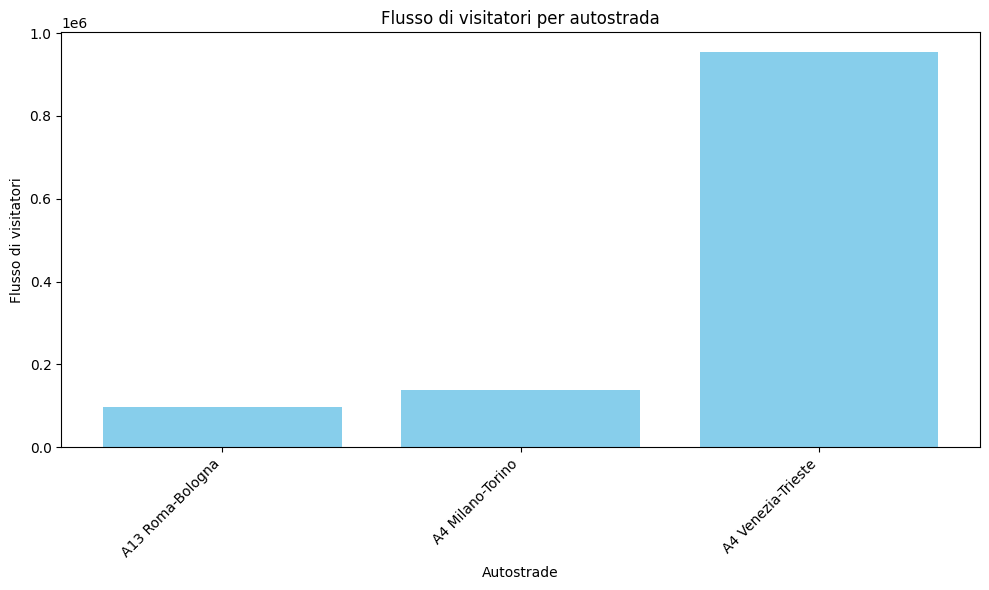

In [64]:
def visitors_fluxes(file_province_codes, file_customers):
    #Consider the three main directions:
    #A13 Roma-Bologna
    #A4 Torino-Milano
    #A4 Trieste-Venezia

    #Consider the istat province codes
    province_codes = pd.read_csv(file_province_codes, encoding='latin1', usecols=['PROVINCIA', 'COD_PRO'])

    #Consider the codes of those six provinces
    province_codes = province_codes.loc[(province_codes['PROVINCIA'] == 'Torino') |
                                    (province_codes['PROVINCIA'] == 'Roma') |
                                    (province_codes['PROVINCIA'] == 'Venezia') |
                                    (province_codes['PROVINCIA'] == 'Bologna') |
                                    (province_codes['PROVINCIA'] == 'Trieste') |
                                    (province_codes['PROVINCIA'] == 'Milano')]
    
    #Now take the data of the customers and see what's their origin and their destination
    # Knowing that (Roma, Bologna), (Torino, Milano), (Trieste, Venezia)
    customers_data = pd.read_csv(file_customers, encoding='latin1', usecols = ['COD_PRO', 'FLOW'])#, 'CUST_CLASS'])

    #Filtering the residents NON SO SE ABBIA SENSO TOGLIERLI PERCHè ANCHE LORO CONTRIBUISCONO AL TRAFFICO
    #customers_data = customers_data.loc[customers_data['CUST_CLASS'] == "visitor"]
    
    #Join between customers_data and province_codes in this way filters the province_codes in which we're not interested
    data = pd.merge(customers_data, province_codes, on='COD_PRO')

    #Counting the flows ov visitors from every city we're interested (both ways)
    data = data.groupby(['PROVINCIA'])[['FLOW']].sum()

    #Saving the informations per highway
    A13_Roma_Bologna = data.FLOW.loc['Roma'] + data.FLOW.loc['Bologna']
    A4_Milano_Torino = data.FLOW.loc['Milano'] + data.FLOW.loc['Torino']
    A4_Venezia_Trieste = data.FLOW.loc['Venezia'] + data.FLOW.loc['Trieste']

    highway = [A13_Roma_Bologna, A4_Milano_Torino, A4_Venezia_Trieste]

    # Etichette per le autostrade
    highway_labels = ["A13 Roma-Bologna", "A4 Milano-Torino", "A4 Venezia-Trieste"]
    
    # Creazione dell'istogramma
    plt.figure(figsize=(10, 6))
    plt.bar(highway_labels, highway, color='skyblue')
    plt.xlabel('Autostrade')
    plt.ylabel('Flusso di visitatori')
    plt.title('Flusso di visitatori per autostrada')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Visualizzazione dell'istogramma
    plt.show()

visitors_fluxes(filename_codici_istat_provincia, filename_day_od)